1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def p(t, tau):
    return (1 - (2**(-t/tau)))

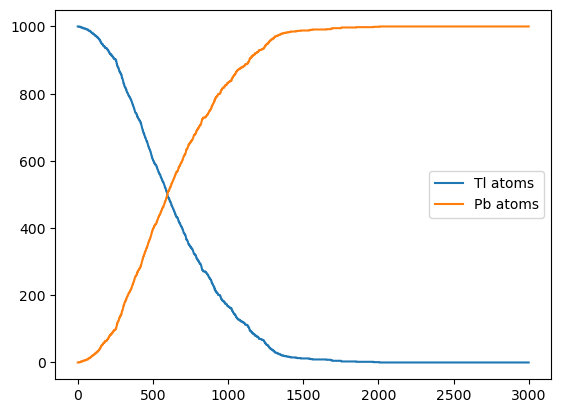

In [3]:
tau = 3052 * 60 # in seconds
N = 1000
tl = [N]
pb = [0]
counter = 3000

for t in range(1, counter):
    atoms = np.random.random(tl[-1])
    d = np.sum(p(t, tau) > atoms)
    tl.append(tl[-1] - d)
    pb.append(pb[-1] + d)

plt.plot(tl)
plt.plot(pb)
plt.legend(["Tl atoms", "Pb atoms"])
plt.show()

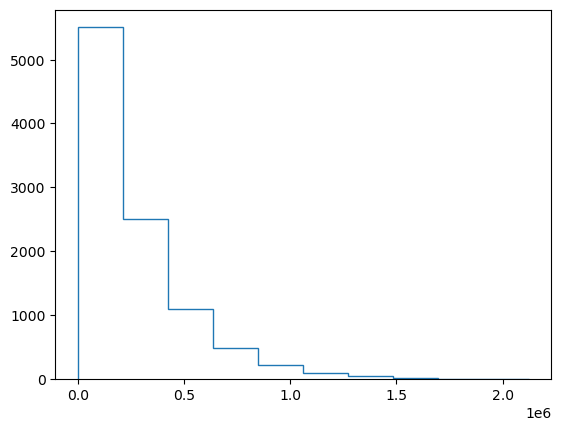

In [4]:
def expon_pdf(x):
    return (2**(-t/(tau))*(np.log(2))/tau)

def expon_icdf(p):
    return (-tau * np.log2(1-p))

u = np.random.random(10000)
v = expon_icdf(u)
plt.hist(v, histtype='step')  
plt.show()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

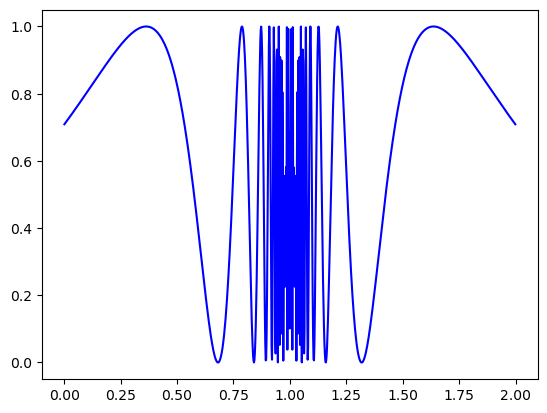

In [5]:
def f(x):
    return np.square(np.sin(1/(1-x)))

x=np.linspace(0.001, 1.999, 1000)
plt.plot(x, f(x), 'b-')

In [6]:
# Hit/Miss Method
N = 100000
count = 0
a = 0
b = 2
for i in range(N):
    x = (b - a) * np.random.random()
    y = np.random.random()
    if y < f(x): count += 1
I_ham = 2 * count / N
print("Integral (Hit/Miss):", I_ham)

Integral (Hit/Miss): 1.3446


In [7]:
# Mean Value Method
x = 2 * np.random.random(N)
I_mvm = (b - a)*np.sum(f(x)) / N
print("Integral (Mean Value):", I_mvm)

Integral (Mean Value): 1.3452705292470974


In [8]:
# error
print("Difference btw 2 integrals: "+str(np.abs(I_mvm - I_ham)))

Difference btw 2 integrals: 0.0006705292470974289


3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [9]:
def f(x): # generalized (x**2 + y**2 + z**2...)
    eq = np.sum(np.square(x))
    if eq <= 1:
        return 1
    return 0

In [10]:
def I(dim, N):
    x = np.random.uniform(-1.0, 1.0, size = (N, dim))
    fs = []
    for i in range(N):
        fs.append(f(x[i]))
    return (2.0**dim)*np.mean(fs)

In [11]:
N = 1000000
print("Integral 2D: "+str(I(2, N)))
print("Integral 10D: "+str(I(10, N)))

Integral 2D: 3.144272
Integral 10D: 2.598912


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [12]:
def f(x):
    return ((x**(-1/2))/(np.exp(x)+1))

def w(x):
    return (1/np.sqrt(x))

In [13]:
n = 10000
y = np.random.random(n)
w_int = np.sum(w(y)) / n
x = np.random.uniform(0, 1, n)**2
h_is = (1.0 / n) * np.sum(f(x) / w(x)) * w_int
print("IS Integral:", h_is)

IS Integral: 0.840194856704287
